**Check GPU connection**


In [1]:
!nvidia-smi

Thu Dec 17 09:53:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Connect to Google Drive**

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import all required libraries**


In [2]:
import random
import time
import tensorflow
import datetime
import sklearn
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Rescaling, Resizing
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from cv2 import cv2

**Create folder for accuracy/loss charts and model summary**

In [7]:
print("Input training name:")
training_name = input()
try:
    path = f"gdrive/MyDrive/BSL/models/{training_name}"
    !mkdir {path}
except:
    print('Path cannot be created')


Input training name:
FINAL


**Convolutional Neural Network (CNN) with 4 conv layers**

Found 3777 files belonging to 10 classes.
Using 3022 files for training.
Found 3777 files belonging to 10 classes.
Using 755 files for validation.
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 128)     3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 88,

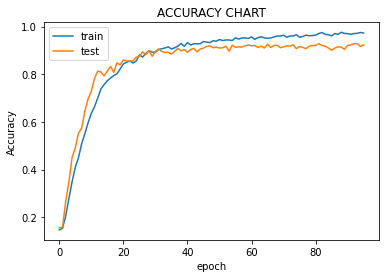

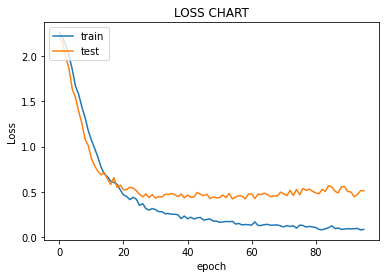

In [8]:
def create_accuracy_chart(history, name):
    ''' Creates Accuracy chart '''

    fig = plt.figure()
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title("ACCURACY CHART")
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('gdrive/MyDrive/BSL/models/{}/Accuracy'.format(name))


def create_loss_chart(history, name):
    ''' Creates Loss chart '''

    fig = plt.figure()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("LOSS CHART")
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('gdrive/MyDrive/BSL/models/{}/Loss'.format(name))


def train(name):
    ''' Train model function '''

    image_shape = (300, 300)
    batch_size = 128
    path = "gdrive/MyDrive/BSL/DATASET/"
    model_path = "gdrive/MyDrive/BSL/model"

    # Gets training data and create keras train-dataset
    train_ds = keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_shape,
        batch_size=batch_size,
        shuffle=True
    )

    # Gets testing data and create keras test-dataset
    val_ds = keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_shape,
        batch_size=batch_size,
        shuffle=True
    )

    # Data augmentation flips randomly input and rotates it by 0.1
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomFlip(
            "horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ])

    # Resizes data to (180, 180) and rescales it to be between 0 and 1 
    data_resize = keras.Sequential([
        Resizing(180, 180),
        Rescaling(1./255)
    ])

    # Begining of the model

    # Input layer reshapes input to be compatibile
    inputs = keras.Input(shape=(300, 300)+(3,))

    # Augmentation resizing and rescaling
    x = data_augmentation(inputs)
    x = data_resize(x)

    # Convolutional layer 1
    x = layers.Conv2D(128, (3, 3), padding='same', activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional layer 2
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional layer 3
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional layer 4
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Dropout to prevent overfitting
    x = layers.Dropout(0.5)(x)

    # Flatten (batch, num)
    x = layers.Flatten()(x)

    # Dense layer with relu activation
    x = layers.Dense(512, activation="relu")(x)

    # Output layer
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Creates and saves model summary as an image
    plot_model(
        model,
        to_file='gdrive/MyDrive/BSL/models/{}/model_summary.png'.format(name),
        show_layer_names=True,
        show_shapes=True
    )

    # Displays model summary in terminal
    model.summary()

    # Sets loss and optomazer algoriths
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Tensorboard
    log_dir = 'gdrive/MyDrive/BSL/models/{}/'.format(name) + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Trains the model and saves it do history variable
    history = model.fit(train_ds, batch_size=batch_size,
                        epochs=96, validation_data=val_ds, callbacks=[tensorboard_callback])

    # Evaluate
    model.evaluate(val_ds, batch_size=batch_size)


    # Create loss and accuracy functions
    create_accuracy_chart(history, name)
    create_loss_chart(history, name)

    # Saves model
    keras.models.save_model(
        model,
        model_path,
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
    )


train(training_name)
